# Train BERT models

## Read data

In [1]:
import os
import re
import pandas as pd
import numpy as np
import random
import sklearn
import codecs
import collections
from tqdm import tqdm
import torch

from sklearn.metrics import classification_report, accuracy_score

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [2]:
TRAIN_DIR = "./data/training/"
TRAIN_SUFFIX = "-train.txt"

DEV_DIR = "./data/development/"
DEV_SUFFIX = "-dev.txt"

TEST_DIR = "./data/test-gold/"
TEST_SUFFIX = "-test-gold.txt"

YEAR_PREFIX = "2018-"
FILE_PREFIX = "EI-oc-En-"

EMOTIONS = ["anger", "fear", "joy", "sadness"] 
LABEL_EMOTIONS = {i: emo for i, emo in enumerate(EMOTIONS)}
EMOTIONS_LABEL = {emo: i for i, emo in enumerate(EMOTIONS)}

In [3]:
TRAIN_FILES = []
DEV_FILES = []
TEST_FILES = []

for emo in EMOTIONS: 
    TRAIN_FILES += [TRAIN_DIR + FILE_PREFIX + emo + TRAIN_SUFFIX]
    DEV_FILES += [DEV_DIR + YEAR_PREFIX + FILE_PREFIX + emo + DEV_SUFFIX]
    TEST_FILES += [TEST_DIR + YEAR_PREFIX + FILE_PREFIX + emo + TEST_SUFFIX]

for file in TRAIN_FILES + DEV_FILES + TEST_FILES:
    print(file, os.path.exists(file))

./data/training/EI-oc-En-anger-train.txt True
./data/training/EI-oc-En-fear-train.txt True
./data/training/EI-oc-En-joy-train.txt True
./data/training/EI-oc-En-sadness-train.txt True
./data/development/2018-EI-oc-En-anger-dev.txt True
./data/development/2018-EI-oc-En-fear-dev.txt True
./data/development/2018-EI-oc-En-joy-dev.txt True
./data/development/2018-EI-oc-En-sadness-dev.txt True
./data/test-gold/2018-EI-oc-En-anger-test-gold.txt True
./data/test-gold/2018-EI-oc-En-fear-test-gold.txt True
./data/test-gold/2018-EI-oc-En-joy-test-gold.txt True
./data/test-gold/2018-EI-oc-En-sadness-test-gold.txt True


In [4]:
TRAIN_DATA = pd.concat(pd.read_csv(f, sep='\t') for f in TRAIN_FILES)
TRAIN_DATA = sklearn.utils.shuffle(TRAIN_DATA)
TRAIN_DATA        

,ID,Tweet,Affect Dimension,Intensity Class
526,2017-En-41199,Incredibly shocked and disappointed with @unit...,sadness,3: high amount of sadness can be inferred
494,2017-En-30873,If yiu don't respond .o an email within 7 days...,joy,0: no joy can be inferred
724,2017-En-30332,Watch this amazing live.ly broadcast by @maisi...,joy,2: moderate amount of joy can be inferred
879,2017-En-31279,But I got to see her last when she was lively ...,joy,0: no joy can be inferred
2095,2017-En-21925,@ThomasHCrown @laurakfillault As a historic ev...,fear,0: no fear can be inferred
...,...,...,...,...
2071,2017-En-22224,today afghanistan tell us where the terrorism ...,fear,2: moderate amount of fear can be inferred
1238,2017-En-31048,#IfIWerePresident \nMy goal would be for us al...,joy,0: no joy can be inferred
1273,2017-En-31241,@1barkcom Thank you for the #follow. Looking f...,joy,2: moderate amount of joy can be inferred
1437,2017-En-31232,"The best part of this day, Jesus, is to snuggl...",joy,3: high amount of joy can be inferred


In [5]:
TRAIN_DATA["Category"] = TRAIN_DATA["Affect Dimension"]
TRAIN_DATA["Label"] = TRAIN_DATA["Affect Dimension"].apply(lambda x: EMOTIONS_LABEL[x])
TRAIN_DATA["Intensity"] = TRAIN_DATA["Intensity Class"].apply(lambda x: int(x[0]))
TRAIN_DATA

,ID,Tweet,Affect Dimension,Intensity Class,Category,Label,Intensity
526,2017-En-41199,Incredibly shocked and disappointed with @unit...,sadness,3: high amount of sadness can be inferred,sadness,3,3
494,2017-En-30873,If yiu don't respond .o an email within 7 days...,joy,0: no joy can be inferred,joy,2,0
724,2017-En-30332,Watch this amazing live.ly broadcast by @maisi...,joy,2: moderate amount of joy can be inferred,joy,2,2
879,2017-En-31279,But I got to see her last when she was lively ...,joy,0: no joy can be inferred,joy,2,0
2095,2017-En-21925,@ThomasHCrown @laurakfillault As a historic ev...,fear,0: no fear can be inferred,fear,1,0
...,...,...,...,...,...,...,...
2071,2017-En-22224,today afghanistan tell us where the terrorism ...,fear,2: moderate amount of fear can be inferred,fear,1,2
1238,2017-En-31048,#IfIWerePresident \nMy goal would be for us al...,joy,0: no joy can be inferred,joy,2,0
1273,2017-En-31241,@1barkcom Thank you for the #follow. Looking f...,joy,2: moderate amount of joy can be inferred,joy,2,2
1437,2017-En-31232,"The best part of this day, Jesus, is to snuggl...",joy,3: high amount of joy can be inferred,joy,2,3


In [6]:
TRAIN_DATA["Category"].value_counts()

fear       2252
anger      1701
joy        1616
sadness    1533
Name: Category, dtype: int64

In [7]:
TRAIN_CATEGORY_WEIGHTS = TRAIN_DATA["Category"].value_counts().to_dict()
TRAIN_LABEL_WEIGHTS =  TRAIN_DATA["Label"].value_counts().to_dict()

In [8]:
DEV_DATA = pd.concat(pd.read_csv(f, sep='\t') for f in DEV_FILES)
DEV_DATA = sklearn.utils.shuffle(DEV_DATA)
DEV_DATA

,ID,Tweet,Affect Dimension,Intensity Class
321,2018-En-01824,God this match is dull #Wimbledon,anger,1: low amount of anger can be inferred
62,2018-En-03227,Not only has my flight been delayed numerous t...,fear,1: low amount of fear can be inferred
327,2018-En-00695,@austin_j_powers @I_am_bumface @R9Rai @Holborn...,fear,1: low amount of fear can be inferred
166,2018-En-03038,James Clapper 'scary and disturbing'. #25thAm...,fear,2: moderate amount of fear can be inferred
369,2018-En-03488,I wish EVERYONE could see how #MSNBC #CNN talk...,anger,1: low amount of anger can be inferred
...,...,...,...,...
55,2018-En-00823,Only halfway through #madeforlove by @AlissaNu...,joy,3: high amount of joy can be inferred
266,2018-En-01671,Nigga write me talking bout I dreamt about you...,sadness,0: no sadness can be inferred
207,2018-En-00657,Damn I'm tired as hell I never get a off day d...,sadness,2: moderate amount of sadness can be inferred
235,2018-En-03719,"The blackest abyss of despair, Alonzo",sadness,2: moderate amount of sadness can be inferred


In [9]:
DEV_DATA["Category"] = DEV_DATA["Affect Dimension"]
DEV_DATA["Label"] = DEV_DATA["Affect Dimension"].apply(lambda x: EMOTIONS_LABEL[x])
DEV_DATA["Intensity"] = DEV_DATA["Intensity Class"].apply(lambda x: int(x[0]))
DEV_DATA

,ID,Tweet,Affect Dimension,Intensity Class,Category,Label,Intensity
321,2018-En-01824,God this match is dull #Wimbledon,anger,1: low amount of anger can be inferred,anger,0,1
62,2018-En-03227,Not only has my flight been delayed numerous t...,fear,1: low amount of fear can be inferred,fear,1,1
327,2018-En-00695,@austin_j_powers @I_am_bumface @R9Rai @Holborn...,fear,1: low amount of fear can be inferred,fear,1,1
166,2018-En-03038,James Clapper 'scary and disturbing'. #25thAm...,fear,2: moderate amount of fear can be inferred,fear,1,2
369,2018-En-03488,I wish EVERYONE could see how #MSNBC #CNN talk...,anger,1: low amount of anger can be inferred,anger,0,1
...,...,...,...,...,...,...,...
55,2018-En-00823,Only halfway through #madeforlove by @AlissaNu...,joy,3: high amount of joy can be inferred,joy,2,3
266,2018-En-01671,Nigga write me talking bout I dreamt about you...,sadness,0: no sadness can be inferred,sadness,3,0
207,2018-En-00657,Damn I'm tired as hell I never get a off day d...,sadness,2: moderate amount of sadness can be inferred,sadness,3,2
235,2018-En-03719,"The blackest abyss of despair, Alonzo",sadness,2: moderate amount of sadness can be inferred,sadness,3,2


## Tweet cleaning

In [10]:
#For Pre-Processing
import emoji
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords
from tqdm import tqdm
from nltk.tokenize import RegexpTokenizer 
from nltk.tokenize import word_tokenize

import nltk
nltk.download('wordnet')

stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# For visualizing
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to /home/cwh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
def decode_emoji(text):
    output = []
    for t in emoji.demojize(text).split():
        output.extend(t.split("_"))
    return ' '.join(output)

def decode_HTML(text):
    return BeautifulSoup(text, 'lxml').get_text()

def remove_mention(text):
    return re.sub(r'@[A-Za-z0-9]+', '', text)
    
def remove_URL(text):
    return re.sub(r"http\S+", "", text)

def remove_punctuation(text):
    return re.sub(r'[^\w\s]', ' ', text)

def correct_repeatted_letters(text):
    return re.sub(r'(.)\1+', r'\1\1', text)

def to_lowercase(text):
    return ' '.join([w.lower() for w in text.split()])
 
def lemmatize_stemming(text):
    return ' '.join([stemmer.stem(lemmatizer.lemmatize(w, pos='v'))
                     for w in text.split()])

def remove_stop_words(text):
    return ' '.join([w for w in text.split() if w not in stop_words])

In [12]:
def pre_process(text):
    text = decode_emoji(text)
    text = decode_HTML(text)
    text = remove_mention(text)
    text = remove_URL(text)
    text = remove_punctuation(text)
    text = correct_repeatted_letters(text)
    text = to_lowercase(text)       
    text = lemmatize_stemming(text)
    text = remove_stop_words(text)
    return text

In [13]:
for t in TRAIN_DATA["Tweet"][:5]:
    print("BEFORE:", t)
    print("AFTER :", pre_process(t))
    print()

BEFORE: Incredibly shocked and disappointed with @united customer service. Really making me rethink flying with them in the future. #unhappy
AFTER : incred shock disappoint custom servic realli make rethink fli futur unhappi

BEFORE: If yiu don't respond .o an email within 7 days, you willxbe killed by an animated gif of the girl froa The Ri.g.
AFTER : yiu respond email within 7 day willxb kill anim gif girl froa ri g

BEFORE: Watch this amazing live.ly broadcast by @maisiev #lively #musically
AFTER : watch amaz live ly broadcast live music

BEFORE: But I got to see her last when she was lively and talkative and I was able to tell her I loved her so that's what matters.
AFTER : get see last live talkat abl tell love matter

BEFORE: @ThomasHCrown @laurakfillault As a historic evangelical, I wonder if the Donatists had a point? What dreadful clergy in my fmr. circles.
AFTER : histor evangel wonder donatist point dread clergi fmr circl



In [14]:
# Train data cleaning
TRAIN_DATA["Text"] = TRAIN_DATA["Tweet"].apply(lambda s: pre_process(s))
TRAIN_DATA["Text_len"] = TRAIN_DATA["Text"].apply(lambda s: len(s.split()))
TRAIN_DATA.head(5)

,ID,Tweet,Affect Dimension,Intensity Class,Category,Label,Intensity,Text,Text_len
526,2017-En-41199,Incredibly shocked and disappointed with @unit...,sadness,3: high amount of sadness can be inferred,sadness,3,3,incred shock disappoint custom servic realli m...,11
494,2017-En-30873,If yiu don't respond .o an email within 7 days...,joy,0: no joy can be inferred,joy,2,0,yiu respond email within 7 day willxb kill ani...,14
724,2017-En-30332,Watch this amazing live.ly broadcast by @maisi...,joy,2: moderate amount of joy can be inferred,joy,2,2,watch amaz live ly broadcast live music,7
879,2017-En-31279,But I got to see her last when she was lively ...,joy,0: no joy can be inferred,joy,2,0,get see last live talkat abl tell love matter,9
2095,2017-En-21925,@ThomasHCrown @laurakfillault As a historic ev...,fear,0: no fear can be inferred,fear,1,0,histor evangel wonder donatist point dread cle...,9


In [15]:
# Dev data cleaning
DEV_DATA["Text"] = DEV_DATA["Tweet"].apply(lambda s: pre_process(s))
DEV_DATA["Text_len"] = DEV_DATA["Text"].apply(lambda s: len(s.split()))
DEV_DATA.head(5)

,ID,Tweet,Affect Dimension,Intensity Class,Category,Label,Intensity,Text,Text_len
321,2018-En-01824,God this match is dull #Wimbledon,anger,1: low amount of anger can be inferred,anger,0,1,god match dull wimbledon,4
62,2018-En-03227,Not only has my flight been delayed numerous t...,fear,1: low amount of fear can be inferred,fear,1,1,onli flight delay numer time provid snack cart...,9
327,2018-En-00695,@austin_j_powers @I_am_bumface @R9Rai @Holborn...,fear,1: low amount of fear can be inferred,fear,1,1,j power bumfac absolut shock behavour,6
166,2018-En-03038,James Clapper 'scary and disturbing'. #25thAm...,fear,2: moderate amount of fear can be inferred,fear,1,2,jam clapper scari disturb 25thamendmentnow imp...,9
369,2018-En-03488,I wish EVERYONE could see how #MSNBC #CNN talk...,anger,1: low amount of anger can be inferred,anger,0,1,wish everyon could see msnbc cnn talk trump sp...,13


count    7102.000000
mean        9.513377
std         4.402350
min         1.000000
25%         6.000000
50%         9.000000
75%        12.000000
max        79.000000
Name: Text_len, dtype: float64


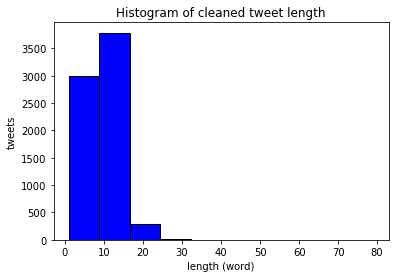

In [16]:
print(TRAIN_DATA["Text_len"].describe())

plt.hist(TRAIN_DATA["Text_len"], color='blue', edgecolor='black')
plt.title('Histogram of cleaned tweet length')
plt.xlabel('length (word)')
plt.ylabel('tweets')
plt.show()

In [17]:
for i, t in TRAIN_DATA.iterrows():
    if t["Text_len"] > 30:
        print("BEFORE:", t["Tweet"])
        print("AFTER :", t["Text"])
        print()

BEFORE: i will never watch greys anatomy ever ever ever ever ever again if Shonda Rimes takes away another OG character☹️☹️☹️☹️☹️☹️☹️☹️☹️☹️ #fuming
AFTER : never watch grey anatomi ever ever ever ever ever shonda rim take away anoth og charact frown face selector frown face selector frown face selector frown face selector frown face selector frown face selector frown face selector frown face selector frown face selector frown face selector fume

BEFORE: Good morning, Trondheim! #optimism #productivity ⛅️❤️🇳🇴🏢💻🖥🏋🏻💪🏼📺🍿
AFTER : good morn trondheim optim product sun behind cloud red heart selector norway offic build laptop comput desktop comput person lift weight light skin tone flex bicep medium light skin tone televis popcorn

BEFORE: i will never watch greys anatomy ever ever ever ever ever again if Shonda Rimes takes away another OG character☹️☹️☹️☹️☹️☹️☹️☹️☹️☹️ 
AFTER : never watch grey anatomi ever ever ever ever ever shonda rim take away anoth og charact frown face selector frown fa

## Data preparation

In [19]:
def prep(data):
    X_data = []
    y_data = []
    
    for X, y in zip(data["Tweet"], data["Label"]):
        words = pre_process(X).split()
        if len(words) > 0:
            X_data.append(pre_process(X))
            y_data.append(y)
            
    return X_data, y_data

In [20]:
X_train, y_train = prep(TRAIN_DATA)
X_dev, y_dev = prep(DEV_DATA)

In [21]:
X_test, y_test = prep(TRAIN_DATA[:10])
X_test, y_test

(['incred shock disappoint custom servic realli make rethink fli futur unhappi',
  'yiu respond email within 7 day willxb kill anim gif girl froa ri g',
  'watch amaz live ly broadcast live music',
  'get see last live talkat abl tell love matter',
  'histor evangel wonder donatist point dread clergi fmr circl',
  'let know',
  'fuck dread live footi match',
  'fell hear snap hffhj',
  'imagin stupid tri chirp becaus racist prick',
  'least crystal everi part portray wrong dark atmospher fact mamoru brainwash'],
 [3, 2, 2, 2, 1, 3, 1, 0, 2, 3])

In [22]:
label_distribution = collections.Counter(y_train)
class_weights = [label_distribution[i] / sum(label_distribution.values()) for i in range(4)]
class_weights

[0.23950999718389185,
 0.31709377640101377,
 0.22754153759504364,
 0.21585468882005068]

In [23]:
PATH = './BERT_working/saved_weights.pt'

In [24]:
# function to predict accuracy
def acc(pred, label):
    pred = torch.argmax(pred, 1)
    return torch.sum(pred == label).item()

In [25]:
# function to plot the accuracy and loss
def plot_acc_loss(tr_acc, vl_acc, tr_loss, vl_loss):
    fig = plt.figure(figsize = (20, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epoch_tr_acc, label='Train Acc')
    plt.plot(epoch_vl_acc, label='Validation Acc')
    plt.title("Accuracy")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(epoch_tr_loss, label='Train loss')
    plt.plot(epoch_vl_loss, label='Validation loss')
    plt.title("Loss")
    plt.legend()
    plt.grid()

    plt.show()

In [26]:
def weights_init_uniform(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.normal_(0.0, 1.0)
        m.bias.data.fill_(0)

## BERT model

In [27]:
import transformers
from transformers import AutoModel, BertTokenizerFast

In [28]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

In [29]:
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [30]:
def tokenizing(text):
    tokens_text = tokenizer.batch_encode_plus(
        text,
        max_length=25,
        padding=True,
#         pad_to_max_length=True,
        truncation=True
    )
    seq = torch.tensor(tokens_text['input_ids'])
    mask = torch.tensor(tokens_text['attention_mask'])
    return seq, mask

In [31]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

## BERT model 1

In [33]:
import torch.nn as nn
import torch.nn.functional as F

class BERT_1(nn.Module):

    def __init__(self, bert):      
        super(BERT_1, self).__init__()
        self.bert = bert
        
        for param in self.bert.parameters():
            param.requires_grad = False
                 
        self.output = nn.Linear(768, 4)

    def forward(self, sent_id, mask):
        out, cls_hs = self.bert(sent_id, attention_mask=mask)
        x = F.relu(cls_hs)
        x = self.output(x)
    
        return x

m = BERT_1(bert)
m.apply(weights_init_uniform)
inputs, masks = tokenizing(X_test)
labels = torch.Tensor(y_test).long()
preds = m(inputs, masks)
print("preds=",torch.argmax(preds, 1))
print("labels=", labels)
print("acc=", acc(preds, labels))

preds= tensor([1, 2, 1, 1, 2, 1, 2, 2, 2, 2])
labels= tensor([3, 2, 2, 2, 1, 3, 1, 0, 2, 3])
acc= 2


## BERT model 2

In [34]:
import torch.nn as nn
import torch.nn.functional as F

class BERT_2(nn.Module):

    def __init__(self, bert):      
        super(BERT_2, self).__init__()
        self.bert = bert
        
        for param in self.bert.parameters():
            param.requires_grad = False          
        self.dropout1 = nn.Dropout(0.1)
        self.fc1 = nn.Linear(768, 128)       
        self.output = nn.Linear(768, 4)

    def forward(self, sent_id, mask):
        out, cls_hs = self.bert(sent_id, attention_mask=mask)
       
        x = self.fc1(F.relu(cls_hs))
        x = self.dropout1(x)
        x = cls_hs
        x = F.relu(x)
        x = self.output(x)
    
        return x

m = BERT_2(bert)
# m.apply(weights_init_uniform)
inputs, masks = tokenizing(X_test)
labels = torch.Tensor(y_test).long()
preds = m(inputs, masks)
print("preds=",torch.argmax(preds, 1))
print("labels=", labels)
print("acc=", acc(preds, labels))

preds= tensor([3, 0, 3, 0, 0, 3, 0, 1, 0, 0])
labels= tensor([3, 2, 2, 2, 1, 3, 1, 0, 2, 3])
acc= 2


In [49]:
# function to train the model
def train():
  
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds=[]
        
    for start in tqdm(range(0, len(X_train), batch_size)):

        inputs, masks = tokenizing(X_train[start: start+batch_size])
        labels = torch.Tensor(y_train[start: start+batch_size]).long()
        
        optimizer.zero_grad()  
        
        preds = model(inputs, masks)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        total_loss = total_loss + loss.item()
        total_preds.extend(preds)

        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

    avg_loss = total_loss / len(X_train) 
    total_preds = [torch.argmax(p, 0) for p in total_preds]
    
    return avg_loss, total_preds

In [50]:
# function for evaluating the model
def evaluate():
    print("\nEvaluating...")
    
    model.eval()
    total_loss, total_accuracy = 0, 0
    total_preds = []

    for start in range(0, len(X_dev), batch_size):

        inputs, masks = tokenizing(X_dev[start: start+batch_size])
        labels = torch.Tensor(y_dev[start: start+batch_size]).long()
        
        # deactivate autograd
        with torch.no_grad():

            preds = model(inputs, masks)

            # compute the validation loss between actual and predicted values
            loss = criterion(preds, labels)
            total_loss = total_loss + loss.item()
            total_preds.extend(preds)

    avg_loss = total_loss / len(X_dev) 
    total_preds = [int(torch.argmax(p, 0)) for p in total_preds]
    return avg_loss, total_preds

In [51]:
from transformers import AdamW

model = BERT_1(bert)
model.apply(weights_init_uniform)

lr = 1e-2
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights))
optimizer = AdamW(model.parameters(), lr=lr)

## Bert For Sequence Classification

In [52]:
epochs = 20
batch_size = 128

# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch+1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, y_pred = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), PATH)
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.6f}')
    print(f'Validation Loss: {valid_loss:.6f}')
    print(f'Validation Acc: {accuracy_score(y_dev, y_pred)}')

  0%|          | 0/56 [00:00<?, ?it/s]


 Epoch 1 / 20


100%|██████████| 56/56 [12:09<00:00, 13.03s/it]



Evaluating...


  0%|          | 0/56 [00:00<?, ?it/s]


Training Loss: 0.090638
Validation Loss: 0.073022
Validation Acc: 0.2652084757347915

 Epoch 2 / 20


100%|██████████| 56/56 [11:49<00:00, 12.68s/it]



Evaluating...


  0%|          | 0/56 [00:00<?, ?it/s]


Training Loss: 0.079705
Validation Loss: 0.067483
Validation Acc: 0.2693096377306904

 Epoch 3 / 20


100%|██████████| 56/56 [11:40<00:00, 12.51s/it]



Evaluating...


  0%|          | 0/56 [00:00<?, ?it/s]


Training Loss: 0.072618
Validation Loss: 0.061018
Validation Acc: 0.2638414217361586

 Epoch 4 / 20


100%|██████████| 56/56 [11:35<00:00, 12.42s/it]



Evaluating...


  0%|          | 0/56 [00:00<?, ?it/s]


Training Loss: 0.065748
Validation Loss: 0.053444
Validation Acc: 0.2563226247436774

 Epoch 5 / 20


100%|██████████| 56/56 [12:10<00:00, 13.04s/it]



Evaluating...


  0%|          | 0/56 [00:00<?, ?it/s]


Training Loss: 0.058255
Validation Loss: 0.050751
Validation Acc: 0.252904989747095

 Epoch 6 / 20


100%|██████████| 56/56 [11:58<00:00, 12.83s/it]



Evaluating...


  0%|          | 0/56 [00:00<?, ?it/s]


Training Loss: 0.054437
Validation Loss: 0.045745
Validation Acc: 0.24606971975393027

 Epoch 7 / 20


100%|██████████| 56/56 [12:06<00:00, 12.96s/it]



Evaluating...


  0%|          | 0/56 [00:00<?, ?it/s]


Training Loss: 0.049665
Validation Loss: 0.044354
Validation Acc: 0.2535885167464115

 Epoch 8 / 20


100%|██████████| 56/56 [12:03<00:00, 12.92s/it]



Evaluating...


  0%|          | 0/56 [00:00<?, ?it/s]


Training Loss: 0.044915
Validation Loss: 0.040259
Validation Acc: 0.2576896787423103

 Epoch 9 / 20


100%|██████████| 56/56 [11:49<00:00, 12.67s/it]



Evaluating...


  0%|          | 0/56 [00:00<?, ?it/s]


Training Loss: 0.042340
Validation Loss: 0.034203
Validation Acc: 0.2522214627477785

 Epoch 10 / 20


100%|██████████| 56/56 [12:17<00:00, 13.16s/it]



Evaluating...


  0%|          | 0/56 [00:00<?, ?it/s]


Training Loss: 0.038215
Validation Loss: 0.036425
Validation Acc: 0.2583732057416268

 Epoch 11 / 20


100%|██████████| 56/56 [12:26<00:00, 13.34s/it]



Evaluating...


  0%|          | 0/56 [00:00<?, ?it/s]


Training Loss: 0.034931
Validation Loss: 0.029965
Validation Acc: 0.2522214627477785

 Epoch 12 / 20


100%|██████████| 56/56 [12:24<00:00, 13.30s/it]



Evaluating...


  0%|          | 0/56 [00:00<?, ?it/s]


Training Loss: 0.032816
Validation Loss: 0.032441
Validation Acc: 0.2583732057416268

 Epoch 13 / 20


100%|██████████| 56/56 [12:23<00:00, 13.27s/it]



Evaluating...


  0%|          | 0/56 [00:00<?, ?it/s]


Training Loss: 0.030237
Validation Loss: 0.022817
Validation Acc: 0.2508544087491456

 Epoch 14 / 20


100%|██████████| 56/56 [12:27<00:00, 13.35s/it]



Evaluating...


  0%|          | 0/56 [00:00<?, ?it/s]


Training Loss: 0.028037
Validation Loss: 0.021570
Validation Acc: 0.2576896787423103

 Epoch 15 / 20


100%|██████████| 56/56 [12:26<00:00, 13.33s/it]



Evaluating...


  0%|          | 0/56 [00:00<?, ?it/s]


Training Loss: 0.025989
Validation Loss: 0.019739
Validation Acc: 0.2522214627477785

 Epoch 16 / 20


100%|██████████| 56/56 [12:24<00:00, 13.30s/it]



Evaluating...


  0%|          | 0/56 [00:00<?, ?it/s]


Training Loss: 0.023389
Validation Loss: 0.019000
Validation Acc: 0.2535885167464115

 Epoch 17 / 20


100%|██████████| 56/56 [12:21<00:00, 13.23s/it]



Evaluating...


  0%|          | 0/56 [00:00<?, ?it/s]


Training Loss: 0.023096
Validation Loss: 0.019545
Validation Acc: 0.2611073137388927

 Epoch 18 / 20


100%|██████████| 56/56 [12:34<00:00, 13.48s/it]



Evaluating...


  0%|          | 0/56 [00:00<?, ?it/s]


Training Loss: 0.020951
Validation Loss: 0.018232
Validation Acc: 0.2631578947368421

 Epoch 19 / 20


100%|██████████| 56/56 [12:48<00:00, 13.73s/it]



Evaluating...


  0%|          | 0/56 [00:00<?, ?it/s]


Training Loss: 0.020610
Validation Loss: 0.018655
Validation Acc: 0.2672590567327409

 Epoch 20 / 20


100%|██████████| 56/56 [12:45<00:00, 13.67s/it]



Evaluating...

Training Loss: 0.018642
Validation Loss: 0.015576
Validation Acc: 0.25153793574846206


In [53]:
model = BERT_2(bert)
model.apply(weights_init_uniform)

lr = 1e-2
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights))
optimizer = AdamW(model.parameters(), lr=lr)

epochs = 20
batch_size = 128

# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch+1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, y_pred = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), PATH)
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.6f}')
    print(f'Validation Loss: {valid_loss:.6f}')
    print(f'Validation Acc: {accuracy_score(y_dev, y_pred)}')

  0%|          | 0/56 [00:00<?, ?it/s]


 Epoch 1 / 20


100%|██████████| 56/56 [12:50<00:00, 13.76s/it]



Evaluating...


  0%|          | 0/56 [00:00<?, ?it/s]


Training Loss: 0.086547
Validation Loss: 0.067970
Validation Acc: 0.2631578947368421

 Epoch 2 / 20


100%|██████████| 56/56 [12:46<00:00, 13.69s/it]



Evaluating...


  0%|          | 0/56 [00:00<?, ?it/s]


Training Loss: 0.076490
Validation Loss: 0.068309
Validation Acc: 0.2679425837320574

 Epoch 3 / 20


100%|██████████| 56/56 [12:54<00:00, 13.82s/it]



Evaluating...


  0%|          | 0/56 [00:00<?, ?it/s]


Training Loss: 0.068645
Validation Loss: 0.059060
Validation Acc: 0.26452494873547505

 Epoch 4 / 20


100%|██████████| 56/56 [12:54<00:00, 13.83s/it]



Evaluating...


  0%|          | 0/56 [00:00<?, ?it/s]


Training Loss: 0.062321
Validation Loss: 0.054547
Validation Acc: 0.26452494873547505

 Epoch 5 / 20


100%|██████████| 56/56 [12:51<00:00, 13.78s/it]



Evaluating...


  0%|          | 0/56 [00:00<?, ?it/s]


Training Loss: 0.055710
Validation Loss: 0.049546
Validation Acc: 0.27204374572795625

 Epoch 6 / 20


100%|██████████| 56/56 [12:47<00:00, 13.70s/it]



Evaluating...


  0%|          | 0/56 [00:00<?, ?it/s]


Training Loss: 0.050315
Validation Loss: 0.038844
Validation Acc: 0.2583732057416268

 Epoch 7 / 20


100%|██████████| 56/56 [12:53<00:00, 13.82s/it]



Evaluating...


  0%|          | 0/56 [00:00<?, ?it/s]


Training Loss: 0.047289
Validation Loss: 0.038445
Validation Acc: 0.2652084757347915

 Epoch 8 / 20


100%|██████████| 56/56 [12:51<00:00, 13.78s/it]



Evaluating...


  0%|          | 0/56 [00:00<?, ?it/s]


Training Loss: 0.042049
Validation Loss: 0.031958
Validation Acc: 0.2638414217361586

 Epoch 9 / 20


100%|██████████| 56/56 [12:47<00:00, 13.70s/it]



Evaluating...


  0%|          | 0/56 [00:00<?, ?it/s]


Training Loss: 0.037897
Validation Loss: 0.028991
Validation Acc: 0.2604237867395762

 Epoch 10 / 20


100%|██████████| 56/56 [12:50<00:00, 13.76s/it]



Evaluating...


  0%|          | 0/56 [00:00<?, ?it/s]


Training Loss: 0.034754
Validation Loss: 0.027737
Validation Acc: 0.254272043745728

 Epoch 11 / 20


100%|██████████| 56/56 [12:51<00:00, 13.78s/it]



Evaluating...


  0%|          | 0/56 [00:00<?, ?it/s]


Training Loss: 0.032368
Validation Loss: 0.028621
Validation Acc: 0.26999316473000684

 Epoch 12 / 20


100%|██████████| 56/56 [12:45<00:00, 13.67s/it]



Evaluating...


  0%|          | 0/56 [00:00<?, ?it/s]


Training Loss: 0.030145
Validation Loss: 0.026748
Validation Acc: 0.2652084757347915

 Epoch 13 / 20


100%|██████████| 56/56 [12:54<00:00, 13.84s/it]



Evaluating...


  0%|          | 0/56 [00:00<?, ?it/s]


Training Loss: 0.027865
Validation Loss: 0.026831
Validation Acc: 0.2693096377306904

 Epoch 14 / 20


100%|██████████| 56/56 [12:39<00:00, 13.55s/it]



Evaluating...


  0%|          | 0/56 [00:00<?, ?it/s]


Training Loss: 0.025390
Validation Loss: 0.024761
Validation Acc: 0.26247436773752564

 Epoch 15 / 20


100%|██████████| 56/56 [10:06<00:00, 10.83s/it]



Evaluating...


  0%|          | 0/56 [00:00<?, ?it/s]


Training Loss: 0.023612
Validation Loss: 0.025774
Validation Acc: 0.2679425837320574

 Epoch 16 / 20


100%|██████████| 56/56 [08:35<00:00,  9.21s/it]



Evaluating...


  0%|          | 0/56 [00:00<?, ?it/s]


Training Loss: 0.021724
Validation Loss: 0.021767
Validation Acc: 0.2672590567327409

 Epoch 17 / 20


100%|██████████| 56/56 [08:39<00:00,  9.28s/it]



Evaluating...


  0%|          | 0/56 [00:00<?, ?it/s]


Training Loss: 0.020218
Validation Loss: 0.022892
Validation Acc: 0.26999316473000684

 Epoch 18 / 20


100%|██████████| 56/56 [10:16<00:00, 11.00s/it]



Evaluating...


  0%|          | 0/56 [00:00<?, ?it/s]


Training Loss: 0.019518
Validation Loss: 0.018379
Validation Acc: 0.26657552973342447

 Epoch 19 / 20


100%|██████████| 56/56 [09:02<00:00,  9.69s/it]



Evaluating...


  0%|          | 0/56 [00:00<?, ?it/s]


Training Loss: 0.018290
Validation Loss: 0.016805
Validation Acc: 0.26657552973342447

 Epoch 20 / 20


100%|██████████| 56/56 [11:25<00:00, 12.24s/it]



Evaluating...

Training Loss: 0.017307
Validation Loss: 0.015800
Validation Acc: 0.2604237867395762


In [29]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 4, 
    output_attentions = False, 
    output_hidden_states = False, 
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/5 [00:00<?, ?it/s]


 Epoch 1 / 10
?? <class 'torch.Tensor'> tensor([[ 0.8951, -0.6133,  0.1833,  0.4108],
        [ 0.9940, -0.5478,  0.5503, -0.1642],
        [ 0.9194, -0.4019,  0.3975, -0.0298],
        [ 0.9032, -0.3978,  0.5459,  0.0700],
        [ 1.0448, -0.7026,  0.4215,  0.0261],
        [ 0.9989, -0.6710,  0.3164,  0.1071],
        [ 0.9330, -0.4710,  0.1595,  0.3788],
        [ 0.9166, -0.4730,  0.6696, -0.2161],
        [ 1.1538, -0.3950,  0.6913,  0.0538],
        [ 0.9665, -0.2964,  0.2146,  0.1344],
        [ 1.0562, -0.4522,  0.4149,  0.0110],
        [ 0.9389, -0.4717,  0.1992,  0.1669],
        [ 0.9330, -0.4296,  0.3340,  0.2592],
        [ 0.9921, -0.5938,  0.5686,  0.0043],
        [ 1.0906, -0.6172,  0.5051,  0.0383],
        [ 0.8713, -0.4409,  0.2331,  0.3689],
        [ 1.1841, -0.5092,  0.2990,  0.0965],
        [ 1.0691, -0.4632,  0.5147, -0.1548],
        [ 1.0943, -0.5166,  0.4472, -0.0991],
        [ 0.9800, -0.6331,  0.4770,  0.1155],
        [ 1.0224, -0.6312,  0.4810,  0.

  0%|          | 0/5 [00:13<?, ?it/s]


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 4, 
    output_attentions = False, 
    output_hidden_states = False, 
)

# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== First Transformer ====\n')
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== Output Layer ====\n')
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
